## Importing and parameter initialiation

In [ ]:
# Tamil QA System - Training Notebook

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Parameters

In [ ]:
# Set parameters
params = {
    'max_length': 384,
    'batch_size': 8,
    'learning_rate': 3e-5,
    'weight_decay': 0.01,
    'epochs': 20,
    'gradient_clipping': 1.0,
    'model_name': 'google/muril-base-cased',
    'random_seed': 42
}

## Dataset loading and preprocessing

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(params['random_seed'])
random.seed(params['random_seed'])
np.random.seed(params['random_seed'])

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(params['model_name'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [ ]:
import json

with open("/content/drive/MyDrive/Final_FYP_Implementations/Datasets and EDA/TaQuAD_final.json", "r", encoding="utf-8") as f:
    data = json.load(f)


In [ ]:
print(type(data))

<class 'dict'>


In [ ]:
from tqdm import tqdm
import torch
from transformers import PreTrainedTokenizer

# Assuming `tokenizer` is a pre-initialized tokenizer (e.g., mBERT or DistilBERT)

# ==== PROCESSING DATA ====
examples = []

for entry in tqdm(data["data"], desc="Processing data"):
    if "paragraphs" not in entry:
        continue  # Skip malformed entry

    for paragraph in entry["paragraphs"]:
        context = paragraph["context"]

        for qa in paragraph["qas"]:
            if qa.get("is_impossible", False):
                continue  # Skip questions marked as impossible

            question = qa["question"]

            for answer in qa["answers"]:
                answer_start = int(answer["answer_start"])
                answer_text = answer["text"]

                # Tokenize the question and context together
                tokenized = tokenizer(
                    question,
                    context,
                    truncation=True,
                    max_length=params['max_length'],
                    padding="max_length",
                    return_offsets_mapping=True,
                    return_tensors="pt"
                )

                offset_mapping = tokenized["offset_mapping"].squeeze(0)
                start_pos, end_pos = None, None

                # Find the start and end positions of the answer within the tokenized input
                for idx, (start, end) in enumerate(offset_mapping):
                    if start <= answer_start < end:
                        start_pos = idx
                    if start < answer_start + len(answer_text) <= end:
                        end_pos = idx
                        break

                if start_pos is None or end_pos is None:
                    continue  # Skip examples where the answer cannot be mapped

                # Append the processed example
                examples.append({
                    "input_ids": tokenized["input_ids"].squeeze(0),
                    "attention_mask": tokenized["attention_mask"].squeeze(0),
                    "start_positions": torch.tensor(start_pos, dtype=torch.long),
                    "end_positions": torch.tensor(end_pos, dtype=torch.long),
                    "domain": answer.get("domain", "unknown") ,
                    "question": question
                })

# Output the total number of examples processed
print(f"Total examples processed: {len(examples)}")


Processing data: 100%|██████████| 240/240 [00:02<00:00, 87.65it/s]

Total examples processed: 741


In [ ]:
import torch
from torch.utils.data import Dataset

# ==== DATASET CLASS ====
class QADataset(Dataset):
    def __init__(self, examples):
        """
        Args:
            examples (list): List of processed examples, each being a dictionary
                             containing 'input_ids', 'attention_mask',
                             'start_positions', 'end_positions', and optionally 'domain' and 'question'.
        """
        self.examples = examples

    def __len__(self):
        """Returns the number of examples in the dataset."""
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index for accessing the individual example.

        Returns:
            dict: Dictionary containing 'input_ids', 'attention_mask',
                  'start_positions', 'end_positions', and 'question'.
        """
        example = self.examples[idx]
        return {
            'input_ids': example["input_ids"],
            'attention_mask': example["attention_mask"],
            'start_positions': example["start_positions"],
            'end_positions': example["end_positions"],
            'question': example["question"],  # Include the question in the dataset
            'domain': example.get("domain", "unknown")
        }


# Instantiate the dataset
dataset = QADataset(examples)


In [ ]:
# Split dataset with seed
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

In [ ]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(params['random_seed']))


In [ ]:
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 592, Val: 74, Test: 75


In [ ]:
train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=params['batch_size'])
test_loader = DataLoader(test_data, batch_size=params['batch_size'])

## Training

In [ ]:
# ==== TRAINING ====
model = AutoModelForQuestionAnswering.from_pretrained(params['model_name'])
model.to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
total_steps = len(train_loader) * params['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
patience = 2
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [] , []

In [ ]:
for epoch in range(params['epochs']):
    print(f"\nEpoch {epoch + 1}/{params['epochs']}")
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clipping'])

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions
            )
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/TaQuAS/MuRIL/muril_droput.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Train Loss: 5.7756 | Val Loss: 5.6351

Epoch 2/20


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Train Loss: 5.5843 | Val Loss: 5.5453

Epoch 3/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Train Loss: 5.4816 | Val Loss: 5.4391

Epoch 4/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Train Loss: 5.3775 | Val Loss: 5.3426

Epoch 5/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Train Loss: 5.2689 | Val Loss: 5.2782

Epoch 6/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Train Loss: 5.1568 | Val Loss: 5.1682

Epoch 7/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Train Loss: 5.0514 | Val Loss: 5.1722

Epoch 8/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Train Loss: 4.9474 | Val Loss: 5.0802

Epoch 9/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Train Loss: 4.8462 | Val Loss: 5.0954

Epoch 10/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Train Loss: 4.7399 | Val Loss: 5.0190

Epoch 11/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Train Loss: 4.6461 | Val Loss: 4.9472

Epoch 12/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Train Loss: 4.5661 | Val Loss: 4.8700

Epoch 13/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Train Loss: 4.4739 | Val Loss: 4.8149

Epoch 14/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Train Loss: 4.3941 | Val Loss: 4.8238

Epoch 15/20


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

Train Loss: 4.3322 | Val Loss: 4.8690
Early stopping triggered.


## Evaluation

In [ ]:
def evaluate_and_save_predictions(test_loader, model, tokenizer, device, output_file="/content/drive/MyDrive/TaQuAS/MuRIL/test_predictions.json"):
    model.eval()
    predictions = []

    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Access question and context (assuming they're in your dataset)
        if 'question' in batch:
            if isinstance(batch['question'], torch.Tensor):
                questions = batch['question'].tolist()
            else:
                questions = batch['question']  # Assume it's already a list
        else:
            questions = [""] * input_ids.size(0)  # Default empty strings

        # Similarly handle context
        if 'context' in batch:
            if isinstance(batch['context'], torch.Tensor):
                contexts = batch['context'].tolist()
            else:
                contexts = batch['context']  # Assume it's already a list
        else:
            contexts = [""] * input_ids.size(0)  # Default empty strings

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for i in range(len(input_ids)):
            # Get predicted answer span
            start_pred = torch.argmax(start_logits[i]).item()
            end_pred = torch.argmax(end_logits[i]).item()

            # Ensure end comes after start and within bounds
            if end_pred < start_pred:
                end_pred = start_pred

            # Get ground truth span (move tensors to CPU first)
            start_true = start_positions[i].cpu().item()
            end_true = end_positions[i].cpu().item()

            # Decode predictions and ground truth
            input_ids_cpu = input_ids[i].cpu().tolist()

            predicted_tokens = tokenizer.convert_ids_to_tokens(input_ids_cpu[start_pred:end_pred+1])
            predicted_answer = tokenizer.convert_tokens_to_string(predicted_tokens)

            true_tokens = tokenizer.convert_ids_to_tokens(input_ids_cpu[start_true:end_true+1])
            true_answer = tokenizer.convert_tokens_to_string(true_tokens)

            # Get question and context (handle different types)
            question = questions[i] if i < len(questions) else ""
            context = contexts[i] if i < len(contexts) else ""

            if isinstance(question, torch.Tensor):
                question = question.cpu().item()
            if isinstance(context, torch.Tensor):
                context = context.cpu().item()

            # Add to predictions
            predictions.append({
                "context": context,
                "question": question,
                "ground_truth": true_answer,
                "predicted_answer": predicted_answer
            })

    # Save predictions
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=4)

    print(f"Saved {len(predictions)} predictions to {output_file}")
    return predictions

In [ ]:
def compute_exact(a_gold, a_pred):
    return int(a_gold.strip() == a_pred.strip())

In [ ]:
import collections

def compute_f1(a_gold, a_pred):
    gold_toks = a_gold.strip().split()
    pred_toks = a_pred.strip().split()
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())

    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0

    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
# First, define the calculation metrics function
def calculate_metrics(predictions):
    exact_match = 0
    f1_total = 0

    for pred in predictions:
        ground_truth = pred["ground_truth"]
        predicted = pred["predicted_answer"]

        exact_match += compute_exact(ground_truth, predicted)
        f1_total += compute_f1(ground_truth, predicted)

    total = len(predictions)
    return {
        "exact_match": exact_match / total * 100,
        "f1": f1_total / total * 100
    }

# Then run the evaluation and ensure it returns the predictions
test_predictions = evaluate_and_save_predictions(
    test_loader,
    model,
    tokenizer,
    device,
    output_file="/content/drive/MyDrive/TaQuAS/MuRIL/test_predictions.json"
)

# Finally calculate and print metrics
metrics = calculate_metrics(test_predictions)
print(f"Exact Match: {metrics['exact_match']:.2f}%")
print(f"F1 Score: {metrics['f1']:.2f}%")

Evaluating: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]

Saved 75 predictions to /content/drive/MyDrive/TaQuAS/MuRIL/test_predictions.json
Exact Match: 34.67%
F1 Score: 56.99%


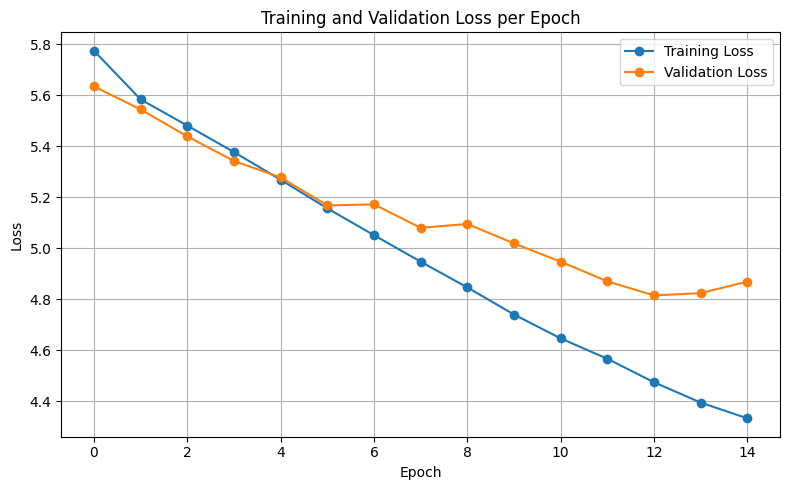

In [ ]:
# ==== PLOT LOSS ====
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Inferencing

In [ ]:
def qa_inference(model_path, paragraph, question, max_length=384):
    """
    Perform inference on a question answering model

    Args:
        model_path (str): Path to the saved model
        paragraph (str): The context paragraph
        question (str): The question to answer based on the paragraph
        max_length (int): Maximum sequence length for the model

    Returns:
        str: The predicted answer
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')
    model = AutoModelForQuestionAnswering.from_pretrained('google/muril-base-cased')

    # Load fine-tuned weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Tokenize input
    inputs = tokenizer(
        question,
        paragraph,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Move inputs to device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get answer
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most probable start and end positions
    start_idx = torch.argmax(start_logits).item()
    end_idx = torch.argmax(end_logits).item()

    # Make sure end_idx comes after start_idx
    if end_idx < start_idx:
        end_idx = start_idx

    # Get the predicted answer tokens and convert to string
    answer_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][start_idx:end_idx+1])
    answer = tokenizer.convert_tokens_to_string(answer_tokens)

    return answer



In [ ]:
if __name__ == "__main__":

    model_path = '/content/drive/MyDrive/Final_FYP_Implementations/Case 2_Finetuning-MuRIL-TaQuAD/muril_droput.pth'


    paragraph = """
    தமிழ் இலக்கியம் பல்லாயிரம் ஆண்டுகளாக வளர்ந்து வந்துள்ளது. சங்க இலக்கியம், பக்தி இலக்கியம்,
    காப்பியங்கள் என்று பல வகைகளில் தமிழ் இலக்கியம் வளர்ந்துள்ளது. திருக்குறள் உலகப் புகழ்பெற்ற
    நீதி நூலாகும். இது திருவள்ளுவரால் எழுதப்பட்டது. இது 1330 குறட்பாக்களைக் கொண்டுள்ளது.
    சிலப்பதிகாரம் ஐம்பெரும் காப்பியங்களில் ஒன்றாகும். இது இளங்கோவடிகளால் எழுதப்பட்டது.
    """

    question = "திருக்குறள் யாரால் எழுதப்பட்டது?"


    answer = qa_inference(model_path, paragraph, question)
    print(f"Question: {question}")
    print(f"Answer: {answer}")

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-71-af414ac48425>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Question: திருக்குறள் யாரால் எழுதப்பட்டது?
Answer: திருவள்ளுவரால்
